# Scattertext spaCy with Yelp Dataset
Exploratory data analysis and visualization for textÂ data

Medium Article - [Analyze Yelp Dataset with Scattertext spaCy](https://link.medium.com/k3DRTC57I1)

[GitHub Repo](https://github.com/gyhou/yelp_dataset)

https://www.yelp.com/dataset/

In [1]:
import pandas as pd

# csv file can be found in the github repo
df = pd.read_csv('yelp_reviews_RV_categories.csv')
print(df.shape)
df.head()

(5342, 15)


business_id                     name  \
0  q0B39iv1bs16PO--eiMfIw      Hobo Camper Country   
1  q0B39iv1bs16PO--eiMfIw      Hobo Camper Country   
2  q0B39iv1bs16PO--eiMfIw      Hobo Camper Country   
3  SW_bePWPlMZJZGQ4eT9vrA  E's RV Appliance Repair   
4  SW_bePWPlMZJZGQ4eT9vrA  E's RV Appliance Repair   

                        address     city state postal_code   latitude  \
0        4020 Edmonton Trail NE  Calgary    AB     T2E 3P6  51.088523   
1        4020 Edmonton Trail NE  Calgary    AB     T2E 3P6  51.088523   
2        4020 Edmonton Trail NE  Calgary    AB     T2E 3P6  51.088523   
3  1959 S Power Rd, Ste 103-238     Mesa    AZ       85206  33.379981   
4  1959 S Power Rd, Ste 103-238     Mesa    AZ       85206  33.379981   

    longitude  stars                                         attributes  \
0 -114.051507    1.5                                                NaN   
1 -114.051507    1.5                                                NaN   
2 -114.051507    1.5                                                NaN   
3 -111.687220    5.0  {'ByAppointmentOnly': 'True', 'BusinessAccepts...   
4 -111.687220    5.0  {'ByAppointmentOnly': 'True', 'BusinessAccepts...   

                                          categories                 user_id  \
0                 RV Repair, Auto Repair, Automotive  DLURbx1V0QyJrntcTyMR4w   
1                 RV Repair, Auto Repair, Automotive  0RsS3-oJ_MBJ-Fb9I-oBhA   
2                 RV Repair, Auto Repair, Automotive  X_W-pHzDboM1jGz60f81cA   
3  Automotive, Water Heater Installation/Repair, ...  pR29E9_ird-h26CY7t18Ag   
4  Automotive, Water Heater Installation/Repair, ...  KGZGa7Hnx6WiAVqtV_uizQ   

   review_stars                                               text  \
0             1  it is todays experience that got HCC (Hobo Cam...   
1             2  Meh, needed parts got attitude.  went somewher...   
2             1  My father took his motorhome in to get the Ant...   
3             5  Eric was great! He diagnosed my LQ horse trail...   
4             5  Always ready to help us whenever we are in tow...   

                  date  
0  2016-09-06 18:06:23  
1  2016-08-11 17:56:24  
2  2016-09-26 02:25:28  
3  2018-05-21 15:46:27  
4  2018-04-29 23:23:56

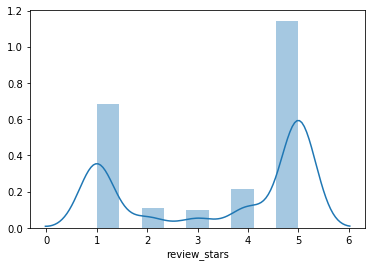

In [3]:
# Check how rating is distributed
import seaborn as sns
sns.distplot(df['review_stars']);

In [4]:
# Consolidate rating to high or low
df['rating'] = df['review_stars'].replace({1:'Low Rating', 2:'Low Rating', 3:'Low Rating',
                                           4:'High Rating', 5:'High Rating'})
df.rating.value_counts()

High Rating    3223
Low Rating     2119
Name: rating, dtype: int64

In [10]:
# Group similar categories
df_RV_Auto = df[df['categories'].str.contains('RV Repair|RV Dealers|RV Rental', case=False, na=False)]
df_Parks_Camp = df[df['categories'].str.contains('RV Parks|Campgrounds', case=False, na=False)]

## Use NLP on review text

In [ ]:
# Make sure you have the english language model
# !python -m spacy download en_core_web_sm

In [11]:
import spacy
import scattertext
# https://spacy.io/models/en
# use the english model that you have
nlp = spacy.load('en_core_web_sm')

In [13]:
# Create a text file to add stop words
with open('stopwords.txt', 'r') as f:
    str_f = f.read()
    stopwords_file = set(str_f.split('\n'))
nlp.Defaults.stop_words |= stopwords_file

In [12]:
# Add more stop words
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords 

### Set up corpus - Term Frequency and Scaled F-Score

In [14]:
def term_freq(df_yelp):
    corpus = (scattertext.CorpusFromPandas(df_yelp,
                                           category_col='rating', 
                                           text_col='text',
                                           nlp=nlp)
              .build()
              .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              )
    
    df = corpus.get_term_freq_df()
    df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
    df['Low_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')

    df['High_Rating_Score'] = round(df['High_Rating_Score'], 2)
    df['Low_Rating_Score'] = round(df['Low_Rating_Score'], 2)
    
    df_high = df.sort_values(by='High Rating freq', 
                             ascending = False).reset_index()
    df_low = df.sort_values(by='Low Rating freq', 
                            ascending=False).reset_index()
    
    return df_high, df_low

In [19]:
# Frequency and Scaled F-Score for RV Parks and Campgrounds
Parks_Camp_high, Parks_Camp_low = term_freq(df_Parks_Camp)

In [20]:
# Sorted by High Rating Frequency
Parks_Camp_high.head(10)

term  High Rating freq  Low Rating freq  High_Rating_Score  \
0      park               583              466               0.90   
1     great               551               88               0.98   
2      nice               483              196               0.95   
3     clean               417              134               0.96   
4      stay               322              248               0.90   
5  friendly               295               83               0.97   
6      pool               270              128               0.94   
7      time               263              263               0.87   
8     staff               251              150               0.92   
9      area               249              124               0.94   

   Low_Rating_Score  
0              0.10  
1              0.02  
2              0.05  
3              0.04  
4              0.10  
5              0.03  
6              0.06  
7              0.13  
8              0.08  
9              0.06

In [21]:
# Sorted by Low Rating Frequency
Parks_Camp_low.head(10)

term  High Rating freq  Low Rating freq  High_Rating_Score  \
0     park               583              466               0.90   
1     time               263              263               0.87   
2     room               159              260               0.10   
3  service               181              256               0.12   
4     stay               322              248               0.90   
5        $                93              209               0.07   
6   people               154              207               0.12   
7     nice               483              196               0.95   
8     good               231              174               0.90   
9    night               122              169               0.12   

   Low_Rating_Score  
0              0.10  
1              0.13  
2              0.90  
3              0.88  
4              0.10  
5              0.93  
6              0.88  
7              0.05  
8              0.10  
9              0.88

In [15]:
# Frequency and Scaled F-Score for RV Repair, RV Dealers and RV Rental
RV_Auto_high, RV_Auto_low = term_freq(df_RV_Auto)

In [16]:
RV_Auto_high.head(10)

term  Low Rating freq  High Rating freq  High_Rating_Score  \
0     service             1393              1551               0.89   
1       great              193              1353               0.98   
2        time              915               988               0.89   
3        work              683               896               0.91   
4     trailer              753               700               0.87   
5         car              602               623               0.89   
6   recommend              164               612               0.97   
7         new              600               612               0.88   
8  experience              403               572               0.92   
9        good              341               519               0.92   

   Low_Rating_Score  
0              0.11  
1              0.02  
2              0.11  
3              0.09  
4              0.13  
5              0.11  
6              0.03  
7              0.12  
8              0.08  
9              0.08

In [17]:
RV_Auto_low.head(10)

term  Low Rating freq  High Rating freq  High_Rating_Score  \
0   service             1393              1551               0.89   
1         $             1086               244               0.04   
2      time              915               988               0.89   
3   trailer              753               700               0.87   
4    called              737               385               0.09   
5      work              683               896               0.91   
6       car              602               623               0.89   
7       new              600               612               0.88   
8  customer              518               459               0.87   
9   company              484               261               0.10   

   Low_Rating_Score  
0              0.11  
1              0.96  
2              0.11  
3              0.13  
4              0.91  
5              0.09  
6              0.11  
7              0.12  
8              0.13  
9              0.90

In [11]:
# Frequency and Scaled F-Score for all 5 RV categories
RV_all_high, RV_all_low = term_freq(df)

In [21]:
RV_all_high.head(10)

term  Low Rating freq  High Rating freq  High_Rating_Score  \
0      great              263              1763               0.98   
1    service             1485              1620               0.89   
2       time             1100              1177               0.89   
3       work              755               935               0.90   
4       nice              357               746               0.94   
5    trailer              805               733               0.87   
6       good              481               698               0.91   
7  recommend              198               694               0.97   
8        new              636               678               0.89   
9        car              633               660               0.88   

   Poor_Rating_Score  
0               0.02  
1               0.11  
2               0.11  
3               0.10  
4               0.06  
5               0.13  
6               0.09  
7               0.03  
8               0.11  
9               0.12

In [20]:
RV_all_low.head(10)

term  Low Rating freq  High Rating freq  High_Rating_Score  \
0   service             1485              1620               0.89   
1         $             1221               320               0.04   
2      time             1100              1177               0.89   
3    called              806               411               0.09   
4   trailer              805               733               0.87   
5      work              755               935               0.90   
6       new              636               678               0.89   
7       car              633               660               0.88   
8  customer              569               484               0.86   
9    people              554               433               0.13   

   Poor_Rating_Score  
0               0.11  
1               0.96  
2               0.11  
3               0.91  
4               0.13  
5               0.10  
6               0.11  
7               0.12  
8               0.14  
9               0.87

## Using Scattertext to visualize term associations

In [40]:
# Label each excerpt with the name of business using the metadata parameter
corpus_dataframe = df_Parks_Camp
html = scattertext.produce_scattertext_explorer(corpus,
                                                category='Low Rating',
                                                category_name='Low Rating',
                                                not_category_name='High Rating',
                                                width_in_pixels=1000,
                                                metadata=corpus_dataframe['name'])

In [41]:
html_file_name = "RV-Parks-Campgrounds-Yelp-Review-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

4574810